In [1]:
import os
import tqdm
import time
import numpy as np
import pandas as pd
from textwrap import wrap
from pathlib import Path
from datetime import datetime
from collections import defaultdict, OrderedDict
import ipywidgets as widgets
from IPython.display import display, Markdown, HTML, clear_output, display_html

import seaborn as sns
from matplotlib import rc
from pylab import rcParams
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import torchtext
from datasets import Dataset
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

from src.train import Train
from src.train.ensemble import Model
from src.train.bert import BertClassifier
from src.config import Config

In [2]:
%config InlineBackend.figure_format = "retina"

sns.set(style="whitegrid", palette="muted", font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams["figure.figsize"] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#### Read in Train, Validation, Test Dataset of Google Play Reviews Data

In [3]:
display(Markdown("<h2>Book Reviews Sentiment Analysis</h2>"))
loading_section       = ["Prepare Model Data", "Data Understanding"]
sections              = ["Train", "Evaluation"]
conclusion_section    = ["Summary"]

train_sub_section   = ["Ensemble Model", "LSTM", "BERT"]
me_sub_section      = ["Model Performance", "Model Interpretability"]

accordions = OrderedDict()
accordions["** Loading **"] = widgets.Accordion(children=[widgets.Output() for section in loading_section])
[accordions["** Loading **"].set_title(i, section) for i, section in enumerate(loading_section)]

for section in sections:
    if section == "Train":
        accordions[section] = widgets.Accordion(children=[widgets.Output() for sub_section in train_sub_section])
        [accordions[section].set_title(i, sub_section) for i, sub_section in enumerate(train_sub_section)]
    else:
        accordions[section] = widgets.Accordion(children=[widgets.Output() for sub_section in me_sub_section])
        [accordions[section].set_title(i, sub_section) for i, sub_section in enumerate(me_sub_section)]
        
accordions["** Conclusion **"] = widgets.Accordion(children=[widgets.Output() for section in conclusion_section])
[accordions["** Conclusion **"].set_title(i, section) for i, section in enumerate(conclusion_section)]
        
widget_fields = widgets.Tab(children=[accordions[t] for t in accordions])
[widget_fields.set_title(i, sub) for i, sub in enumerate(accordions.keys())]

<h2>Book Reviews Sentiment Analysis</h2>

[None, None, None, None]

In [4]:
widget_fields

In [5]:
train = Train(target_var="sentiment", predictives="reviews", suffix="")
self = train

# model = Model(m=CLASSFICATION_ALGORITHMS["LGBMC_TUNED"], target_var="sentiment", predictives="reviews")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
%matplotlib agg

with accordions["** Loading **"].children[0]:
    clear_output()
    display(Markdown("<h2> Initiating Modelling Data Preparation ... </h2>"))
    train.get_reviews_data()
    train.prepare_model_data(reviews_df=train.data["reviews_abt"])
    
    
with accordions["** Loading **"].children[1]:
    clear_output()
    display(Markdown("<h2> 1. Understand Distribution of Sentiment Across Data ... </h2>"))
    train_count_df = train.data["train_df"]["sentiment"].value_counts(normalize=True).reset_index()
    train_count_df["group"] = "train"
    test_count_df = train.data["test_df"]["sentiment"].value_counts(normalize=True).reset_index()
    test_count_df["group"] = "test"
    val_count_df = train.data["val_df"]["sentiment"].value_counts(normalize=True).reset_index()
    val_count_df["group"] = "val"
    sentiment_count_df = pd.concat([train_count_df, test_count_df, val_count_df], axis=0)
    sentiment_count_df["proportion"] = round(sentiment_count_df["proportion"], 3)
    display(train.vertical_bar_plot(df=sentiment_count_df, 
                                    xvar="sentiment", 
                                    yvar="proportion", 
                                    hue="group", 
                                    title="Distribution of Sentiments Across Train-Test-Validation Data"))
    
    display(Markdown("<h2> 2. Understand Tokens Length of Each Reviews ... </h2>"))
    # token_lens = []
    # for txt in train.data["train_df"].reviews:
    #     tokens = train.tokenizer.encode(txt, max_length=512, truncation=True)
    #     token_lens.append(len(tokens))
    # display(train.tokens_lens_plot(xvar=token_lens, title="Length of Tokens of Reviews"))

In [7]:
data = next(iter(train.train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

### Modelling
1. BERT
2. LSTM

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [34]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
# from ignite.metrics import Accuracy, Precision, Recall, Fbeta

from sklearn.metrics import confusion_matrix, classification_report

In [42]:
class ReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
        
    def __len__(self):
        return len(self.reviews)
  
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
    
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors="pt",
            )

        return {
            "review_text": review,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "targets": torch.tensor(target, dtype=torch.long)
            }

In [43]:
def create_data_loader(self, df, tokenizer, max_len, batch_size):
    ds = ReviewDataset(
        reviews=df["reviews"].to_numpy(), 
        targets=df["sentiment"].to_numpy(), 
        tokenizer=tokenizer, 
        max_len=max_len
        )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

### BERT

In [19]:
PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'
# Lets load pre-trained Distill BertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [31]:
model = DistilBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels = 2)
model = model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

In [33]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr = 5e-5)
total_steps = len(train.train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [35]:
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):

  model = model.train()    # tells your model that we are training
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    loss, logits = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      labels = targets
    )
    
    # logits = classification scores befroe softmax
    # loss = classification loss
    
    logits = logits.detach().cpu().numpy()
    label_ids = targets.to('cpu').numpy()

    preds = np.argmax(logits, axis=1).flatten()   #returns indices of maximum logit
    targ = label_ids.flatten()

    correct_predictions += np.sum(preds == targ)

    losses.append(loss.item())
    loss.backward()   # performs backpropagation(computes derivates of loss w.r.t to parameters)
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #clipping gradients so they dont explode
    optimizer.step()       #After gradients are computed by loss.backward() this makes the optimizer iterate over all parameters it is supposed to update and use internally #stored grad to update their values
    scheduler.step()    # this will make sure learning rate changes. If we dont provide this learning rate stays at initial value
    optimizer.zero_grad()     # clears old gradients from last step

  return correct_predictions / n_examples, np.mean(losses)

In [56]:
for d in train.train_data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    loss, logits = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      labels = targets
    )
    
    print(loss, logits)
    
    break

loss logits


In [57]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [53]:
train_acc, train_loss = train_epoch(model, train.train_data_loader, optimizer, device, scheduler, len(train.data["train_df"]))

AttributeError: 'str' object has no attribute 'detach'

In [36]:
def eval_model(model, data_loader, device, n_examples):
  
  model = model.eval()   # tells model we are in validation mode
  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      loss, logits = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        labels = targets
      )
      
      logits = logits.detach().cpu().numpy()
      label_ids = targets.to('cpu').numpy()

      preds = np.argmax(logits, axis=1).flatten()
      targ = label_ids.flatten()

      correct_predictions += np.sum(preds == targ)
      losses.append(loss.item())

  return correct_predictions / n_examples, np.mean(losses)

In [44]:
%%time
# standard block
# used accuracy as metric here
history = defaultdict(list)

best_acc = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model, train.train_data_loader, optimizer, device, scheduler, len(train.data["train_df"]))

  print(f'Train loss {train_loss} Accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, train.valid_data_loader, device, len(df_valid))

  print(f'Val   loss {val_loss} Accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_acc:
    torch.save(model.state_dict(), 'best_model_state_a5.bin')
    best_acc = val_acc

# We are storing state of best model indicated by highest validation accuracy

Epoch 1/5
----------


AttributeError: 'str' object has no attribute 'detach'

In [10]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
     
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
      )
    output = self.drop(pooled_output)
    return self.out(output)

In [22]:
class_names = train.data["train_df"]["sentiment"].unique()

model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
input_ids = data["input_ids"].to(device)
attention_mask = data["attention_mask"].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([8, 256])
torch.Size([8, 256])


In [27]:
model(input_ids, attention_mask)

RuntimeError: CUDA error: CUBLAS_STATUS_NOT_INITIALIZED when calling `cublasCreate(handle)`

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = (
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [11]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()
    
    losses = []
    correct_positions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, pred = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds=targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clips_grad_norm(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optmizer.zero_grad()
        
    return correct_predictions.double() / n_examples, np.mean(losses)

### LSTM

In [ ]:
no_layers = 2
vocab_size = len(vocab) + 1
embedding_dim = 64
output_dim = 1
hidden_dim = 256

model = LSTMClassifier(no_layers, vocab_size, hidden_dim, embedding_dim, drop_prob=0.5)
model.to(device)

print(model)

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
clip = 5
epochs = 5
valid_loss_fn = np.Inf
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []


for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    
    h = model.init_hidden_size(batch_size)
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # # Creating new variables for the hidden state, otherwise backprop through the entire training history
        h = tuple([each.data for each in h])
        model.zero_grad()
        output, h = model(inputs, h)
        
        # # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train.losses.append(loss.item())
        
        accuracy = acc(output, labels)
        train_acc += accuracy
        
        # # clip_norm_grad helps prevent the exploding gradient problem in RNNs/LSTMs
        nn.utils.clip_norm_grad(model.parameters(), clip)
        optimizer.step()
        
    val_h = model.init_hidden_size(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
        val_h = tuple([each.data for each in val_h])
        
        inputs, labels = inputs.to(device), labels.to(device)
        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())
        
        val_losses.append(val_loss.item())
        accuracy = acc(output, labels)
        val_acc += accuracy
        
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    
    print(f"Epoch {epoch+1}")
    print(f"train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}")
    print(f"train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}")
    
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), "../working/state_dict.pt")
        print("Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(35*"==")

## Appendix

In [23]:
token_lens = []

for txt in train.data["train_df"].reviews:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

In [30]:
def distribution_plot(xvar, title=None):
    fig, ax = plt.subplots(figsize=(10,4))
    sns.distplot(x=xvar, ax=ax)
    ax.set_title(title, fontsize=12, weight="bold")
    ax.set_ylabel("Density", fontsize=10)
    
    return fig

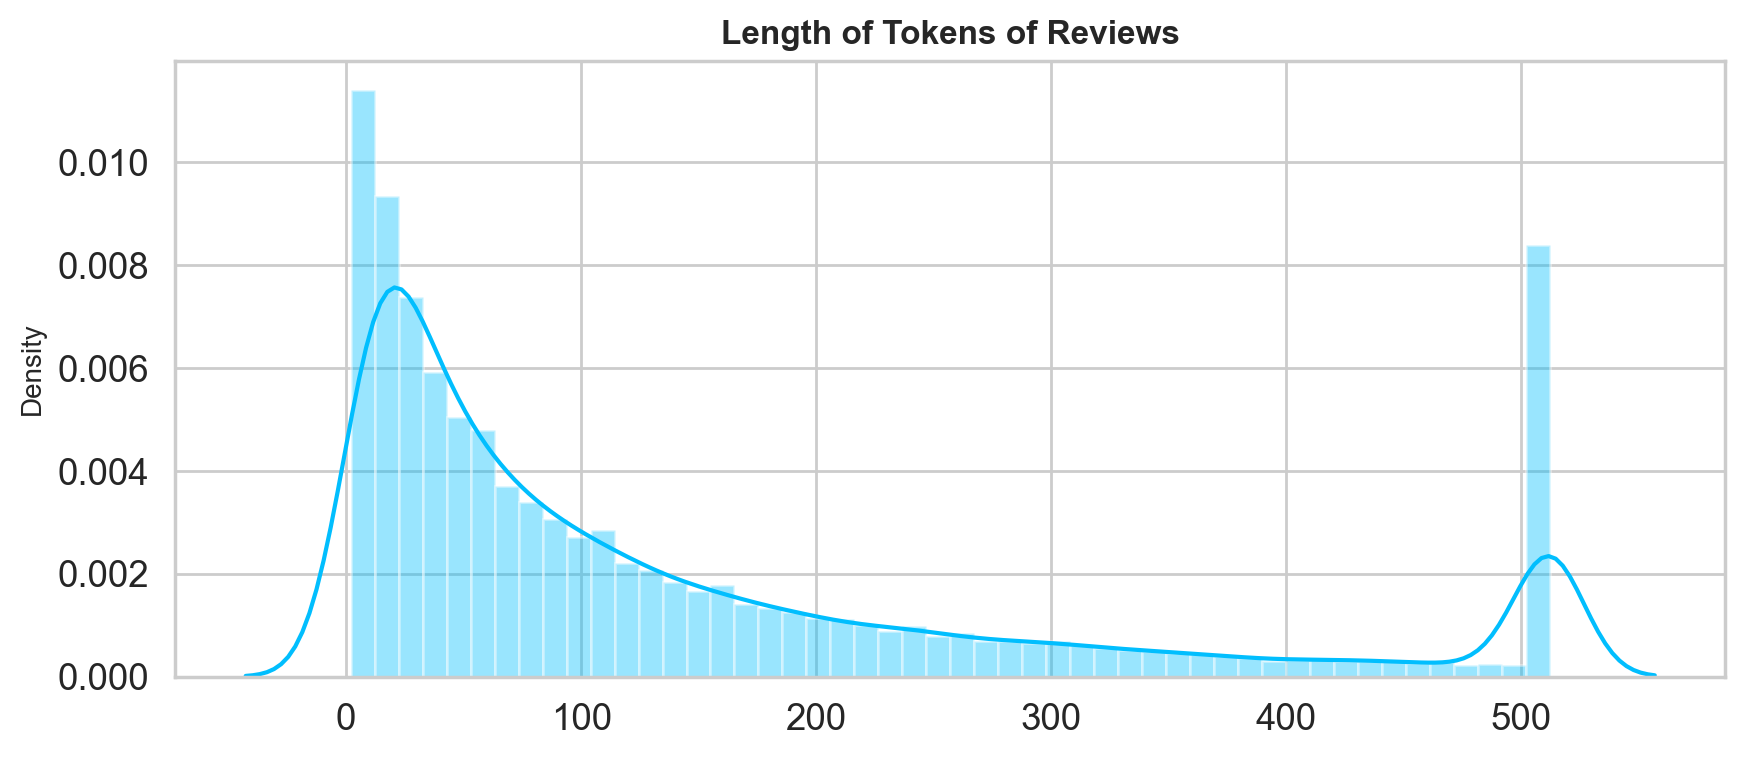

In [31]:

distribution_plot(xvar=token_lens, title="Length of Tokens of Reviews")

In [7]:
class ReviewDataset(Dataset):
    def __init__(self, review, target, tokenizer, max_len):
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
        
        
    def __len__(self):
        return len(self.review)
    
    
    def __getitem__(self, item):
        review = str(self.review[item])
        
        encoding = tokenizer.encode_plus(
            review,
            max_length=self.max_len,
            truncation=True,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_token_type_ids=False,
            return_tensors="pt"
        )
        
        return {
            "input_ids": encoding["input_ids"],
            "attention_mask": encoding["attention_mask"],
            "targets": torch.tensor(self.target[item], dtype=torch.long)
        }

In [12]:
def tokenize_data(example, tokenizer, max_length=256):
    tokens = tokenizer(example["reviews"])[:max_length]
    length = len(tokens)
    
    return {"tokens": tokens, "length": length}

In [17]:
# from torch.utils.data import Dataset
from datasets import Dataset

In [18]:
self.logger.info("  initiate English tokenizer from ...")
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

self.logger.info("  creating Data Dictionary Object...")
self.logger.info("    > train data")
train_dict = train_df[["reviews", "sentiment"]].to_dict(orient="list")
train_data = Dataset.from_dict(train_dict)

self.logger.info("    > test data")
test_dict = test_df[["reviews", "sentiment"]].to_dict(orient="list")
test_data = Dataset.from_dict(test_dict)

self.logger.info("    > validation data")
val_dict = val_df[["reviews", "sentiment"]].to_dict(orient="list")
val_data = Dataset.from_dict(val_dict)

  initiate English tokenizer from ...
  creating Data Dictionary Object...
    > train data
    > test data
    > validation data


In [19]:
max_length = 128

self.logger.info("  creating tokens & length of tokens info...")
self.logger.info("    > train data")
train_data = train_data.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})

self.logger.info("    > test data")
test_data = test_data.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})

self.logger.info("    > validation data")
val_data = val_data.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})

  creating tokens & length of tokens info...
    > train data


Map:   0%|          | 0/121612 [00:00<?, ? examples/s]

    > test data


Map:   0%|          | 0/38005 [00:00<?, ? examples/s]

    > validation data


Map:   0%|          | 0/30404 [00:00<?, ? examples/s]

In [20]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"]
vocab = torchtext.vocab.build_vocab_from_iterator(train_data["tokens"],
                                                  min_freq=min_freq,
                                                  specials=special_tokens)

unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]
vocab.set_default_index(unk_index)

In [21]:
def numericalize_data(example, vocab):
    ids = [vocab[token] for token in example["tokens"]]
    
    return {"ids": ids}

In [22]:
self.logger.info("  numericalize text data...")
self.logger.info("    > train data")
train_data = train_data.map(numericalize_data, fn_kwargs={'vocab': vocab})
self.logger.info("    > test data")
test_data = test_data.map(numericalize_data, fn_kwargs={'vocab': vocab})
self.logger.info("    > validation data")
val_data = val_data.map(numericalize_data, fn_kwargs={'vocab': vocab})

  numericalize text data...
    > train data


Map:   0%|          | 0/121612 [00:00<?, ? examples/s]

    > test data


Map:   0%|          | 0/38005 [00:00<?, ? examples/s]

    > validation data


Map:   0%|          | 0/30404 [00:00<?, ? examples/s]

In [23]:
self.logger.info("  transform data into Pytorch format...")
self.logger.info("    > train data")
train_data = train_data.with_format(type="torch", columns=["ids", "sentiment", "length"])
self.logger.info("    > test data")
test_data = test_data.with_format(type="torch", columns=["ids", "sentiment", "length"])
self.logger.info("    > validation data")
val_data = val_data.with_format(type="torch", columns=["ids", "sentiment", "length"])

  transform data into Pytorch format...
    > train data
    > test data
    > validation data


In [24]:
train_data_df = pd.DataFrame.from_dict(train_data)

In [25]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(121612, 5)
(38005, 5)
(30404, 5)


In [30]:
import os
import glob

def read_imdb_data(data_dir='imdb_data/aclImdb'):
    data = {}
    labels = {}
    
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}
        
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            for f in files:
                with open(f, encoding='utf8') as review:
                    data[data_type][sentiment].append(review.read())
                    # Here we represent a positive review by '1' and a negative review by '0'
                    labels[data_type][sentiment].append(1 if sentiment == 'pos' else 0)
                    
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
                
    return data, labels

In [31]:
data, labels = read_imdb_data()
print("IMDB reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
            len(data['train']['pos']), len(data['train']['neg']),
            len(data['test']['pos']), len(data['test']['neg'])))

IMDB reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


In [39]:
from sklearn.utils import shuffle

def prepare_imdb_data(data, labels):
    """Prepare training and test sets from IMDb movie reviews."""
    
    #Combine positive and negative reviews and labels
    data_train = data['train']['pos'] + data['train']['neg']
    data_test = data['test']['pos'] + data['test']['neg']
    labels_train = labels['train']['pos'] + labels['train']['neg']
    labels_test = labels['test']['pos'] + labels['test']['neg']
    
    #Shuffle reviews and corresponding labels within training and test sets
    data_train, labels_train = shuffle(data_train, labels_train)
    data_test, labels_test = shuffle(data_test, labels_test)
    
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test

In [53]:
train_X, test_X, train_y, test_y = prepare_imdb_data(data, labels)
print("IMDb reviews (combined): train = {}, test = {}".format(len(train_X), len(test_X)))

IMDb reviews (combined): train = 25000, test = 25000


In [42]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

import re
from bs4 import BeautifulSoup

def review_to_words(review):
    nltk.download("stopwords", quiet=True)
    stemmer = PorterStemmer()
    
    text = BeautifulSoup(review, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem
    
    return words

In [82]:
import pickle

cache_dir = os.path.join("cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        #words_train = list(map(review_to_words, data_train))
        #words_test = list(map(review_to_words, data_test))
        words_train = [review_to_words(review) for review in data_train]
        words_test = [review_to_words(review) for review in data_test]
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test

In [83]:
train_X, test_X, train_y, test_y = preprocess_data(train_X, test_X, train_y, test_y)

Wrote preprocessed data to cache file: preprocessed_data.pkl


In [152]:
train_X, test_X, train_y, test_y = preprocess_data(train_dict["reviews"], test_dict["reviews"], 
                                                   train_dict["sentiment"], test_dict["sentiment"])

Read preprocessed data from cache file: preprocessed_data.pkl


In [154]:
import numpy as np

def build_dict(data, vocab_size = 5000):
    """Construct and return a dictionary mapping each of the most frequently appearing words to a unique integer."""
    
    # TODO: Determine how often each word appears in `data`. Note that `data` is a list of sentences and that a
    #       sentence is a list of words.
    
    word_count = {} # A dict storing the words that appear in the reviews along with how often they occur
    
    for review in data:
        for word in review:
            if word in word_count:
                word_count[word] += 1
            else:
                word_count[word] = 1
    
    # TODO: Sort the words found in `data` so that sorted_words[0] is the most frequently appearing word and
    #       sorted_words[-1] is the least frequently appearing word.
    
    sorted_words = [k for k, v in sorted(word_count.items(), key=lambda item: item[1], reverse=True)]
    
    word_dict = {} # This is what we are building, a dictionary that translates words into integers
    for idx, word in enumerate(sorted_words[:vocab_size - 2]): # The -2 is so that we save room for the 'no word'
        word_dict[word] = idx + 2                              # 'infrequent' labels
        
    return word_dict

In [155]:
word_dict = build_dict(train_X)

In [159]:
data_dir = 'data/pytorch' # The folder we will use for storing data
if not os.path.exists(data_dir): # Make sure that the folder exists
    os.makedirs(data_dir)

In [160]:
with open(os.path.join(data_dir, 'word_dict.pkl'), "wb") as f:
    pickle.dump(word_dict, f)

In [142]:
train_word_dict = build_dict(train_dict["reviews"])

with open(os.path.join(data_dir, 'word_dict.pkl'), "wb") as f:
    pickle.dump(word_dict, f)

In [88]:
def convert_and_pad(word_dict, sentence, pad=500):
    NOWORD = 0 # We will use 0 to represent the 'no word' category
    INFREQ = 1 # and we use 1 to represent the infrequent words, i.e., words not appearing in word_dict
    
    working_sentence = [NOWORD] * pad
    
    for word_index, word in enumerate(sentence[:pad]):
        if word in word_dict:
            working_sentence[word_index] = word_dict[word]
        else:
            working_sentence[word_index] = INFREQ
            
    return working_sentence, min(len(sentence), pad)

def convert_and_pad_data(word_dict, data, pad=500):
    result = []
    lengths = []
    
    for sentence in data:
        converted, leng = convert_and_pad(word_dict, sentence, pad)
        result.append(converted)
        lengths.append(leng)
        
    return np.array(result), np.array(lengths)

In [89]:
train_X, train_X_len = convert_and_pad_data(word_dict, train_X)
test_X, test_X_len = convert_and_pad_data(word_dict, test_X)

In [91]:
print("Lenght of 51th review: ", len(train_X[50]))
print("All values in scope: ", len([1 for num in train_X[50] if num >=0 and num <= 4998]) == len(train_X[50]))
train_X[50]

Lenght of 51th review:  500
All values in scope:  True


array([2211,  312, 3761, 1438, 2635, 2337,  490,  316, 2014,   38,    1,
       1438,   52,    1, 1123,  685,  115, 2831,   95,  888,   39,    4,
       3761,   90, 2211,  121,  804,  177, 1006, 1258,   27,  173,   84,
        296,    1,   31,   79,  176,  182, 3916, 2584,  235,  623,  437,
        867, 1448,    4,  285,  136,  579,  115,   27, 1566,  246,  563,
       1306,   11,   31,    4,   76,  227,    1,  214, 1435, 2910,   72,
        168,   20,    2,  139,   93,  326,   33,   71,    1,    5, 1269,
       2472,  872,  237,   29,   11,  313,    1, 2814,  147,   84,    6,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [104]:
pd.concat([pd.DataFrame(train_y), pd.DataFrame(train_X_len), pd.DataFrame(train_X)], axis=1) \
        .to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [107]:
pd.concat([pd.DataFrame(train_y), pd.DataFrame(train_X_len), pd.DataFrame(train_X)], axis=1)

,0,0,0,1,2,3,4,5,6,7,...,490,491,492,493,494,495,496,497,498,499
0,0,79,55,287,229,1267,1,1,4095,1,...,0,0,0,0,0,0,0,0,0,0
1,1,126,1,76,3219,3007,954,2032,508,1246,...,0,0,0,0,0,0,0,0,0,0
2,0,225,2,514,348,233,184,16,186,580,...,0,0,0,0,0,0,0,0,0,0
3,0,135,3,87,1,1647,55,3731,243,819,...,0,0,0,0,0,0,0,0,0,0
4,0,189,12,91,536,643,10,1,3,150,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,82,243,694,411,335,2744,97,95,63,...,0,0,0,0,0,0,0,0,0,0
24996,1,44,37,719,341,2224,2101,531,30,17,...,0,0,0,0,0,0,0,0,0,0
24997,0,134,224,403,4365,11,1886,2,49,37,...,0,0,0,0,0,0,0,0,0,0
24998,1,166,29,20,849,59,12,28,506,197,...,0,0,0,0,0,0,0,0,0,0


In [126]:
transformed_train_X, transformed_train_train_X_len = convert_and_pad_data(word_dict, train_dict["reviews"])
transformed_test_X, transformed_test_X_len = convert_and_pad_data(word_dict, test_dict["reviews"])

In [111]:
train_data["sentiment"]

tensor([0, 1, 1,  ..., 1, 0, 1])

In [68]:
print("Lenght of 51th review: ", len(transformed_train_X[50]))
print("All values in scope: ", len([1 for num in transformed_train_X[50] if num >=0 and num <= 4998]) == len(transformed_train_X[50]))
transformed_train_X[50]

Lenght of 51th review:  500
All values in scope:  True


array([ 4,  3, 10, 10,  7, 21, 12, 18,  2,  7, 16, 22, 10,  3,  8,  8,  2,
       21,  6,  6, 26,  2, 21, 15,  4,  8, 14, 11,  3, 10,  2,  5, 22, 22,
        3,  5, 10,  2, 16,  3, 10,  3, 12, 18,  2,  4, 10, 18,  2, 22, 12,
        5,  4, 11,  2, 14,  5,  8, 11,  2, 14,  6, 20,  2, 22, 10,  3,  4,
        4, 18,  2, 14,  6, 12, 12,  3, 14,  4,  3, 13,  2, 22,  6,  3, 16,
        2, 22, 12,  5,  4, 11,  2, 22, 12,  5,  4, 11,  2, 16, 18,  4, 11,
        2, 19, 15,  5, 10,  5,  9,  4,  3,  3,  2,  8,  5, 12,  3,  2, 13,
        7,  8, 12,  7, 26,  3,  2, 17,  5, 14,  4,  2,  4,  3,  9, 13,  2,
       15,  8,  3,  2, 22, 10,  7, 16,  5, 10, 18,  2,  8,  6, 15, 10, 14,
        3,  2, 13,  3,  8, 22,  7,  4,  3,  2, 17,  5, 14,  4,  2, 16,  5,
       43,  6, 10,  2, 22, 12,  5, 18,  3, 10,  2, 12,  7, 17,  3,  2,  4,
        3, 13,  2, 11, 15, 19, 11,  3,  8,  2,  5, 15, 10,  3, 12,  7,  5,
        2, 22, 12,  5,  4, 11,  2,  5, 12,  7, 24,  3,  2,  5, 22, 22,  3,
        5, 10,  2,  8,  3

## LSTM Model

In [124]:
class LSTMClassifier(nn.Module):
    """
    This is the simple RNN model we will be using to perform Sentiment Analysis.
    """
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        """
        Initialize the model by settingg up the various layers.
        """
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.dense = nn.Linear(in_features=hidden_dim, out_features=1)
        self.sig = nn.Sigmoid()
        self.word_dict = None
        

    def forward(self, x):
        """
        Perform a forward pass of our model on some input.
        """
        x = x.t()
        lengths = x[0,:]
        reviews = x[1:,:]
        embeds = self.embedding(reviews)
        lstm_out, _ = self.lstm(embeds)
        out = self.dense(lstm_out)
        out = out[lengths - 1, range(len(lengths))]
        return self.sig(out.squeeze())

In [182]:
def train(model, train_loader, epochs, optimizer, loss_fn, device):
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for batch in train_loader:         
            batch_X, batch_y = batch
            
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            # TODO: Complete this train method to train the model provided.
            model.to(device)
            optimizer.zero_grad()
        
            ps = model(batch_X)
            loss = loss_fn(ps, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.data.item()
        print("Epoch: {}, BCELoss: {}".format(epoch, total_loss / len(train_loader)))
    
    model_id = str(datetime.now()).split(" ")[0].replace("-", "_") + \
            str(datetime.now()).split(" ")[1].split(".")[0].replace(":", "_")
    model_path = os.path.join(self.FILES["MODEL_DATA_DIR"], "lstm_model_{}.pth".format(model_id))
    torch.save(model.state_dict(), model_path)
    
    return model

In [105]:
train_sample = pd.read_csv(os.path.join(data_dir, 'train.csv'), header=None, names=None, nrows=250)

In [114]:
transform_train_sample = pd.concat([pd.DataFrame(train_dict["sentiment"]), 
                                    pd.DataFrame(transformed_train_train_X_len), 
                                    pd.DataFrame(transformed_train_X)], axis=1)
transform_train_sample.columns = [str(i) for i in range(len(transform_train_sample.columns))]

In [116]:
train_sample_y = torch.from_numpy(train_sample[[0]].values).float().squeeze()
train_sample_X = torch.from_numpy(train_sample.drop([0], axis=1).values).long()

In [120]:
# Build the dataset
train_sample_ds = torch.utils.data.TensorDataset(train_sample_X, train_sample_y)
# Build the dataloader
train_sample_dl = torch.utils.data.DataLoader(train_sample_ds, batch_size=50)

In [186]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(32, 100, 5000).to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

train(model, train_sample_dl, 50, optimizer, loss_fn, device)

Epoch: 1, BCELoss: 0.6997045278549194
Epoch: 2, BCELoss: 0.6906813263893128
Epoch: 3, BCELoss: 0.6836840033531189
Epoch: 4, BCELoss: 0.6765644550323486
Epoch: 5, BCELoss: 0.6684593081474304
Epoch: 6, BCELoss: 0.658358097076416
Epoch: 7, BCELoss: 0.6447415709495544
Epoch: 8, BCELoss: 0.6248663425445556
Epoch: 9, BCELoss: 0.5931399941444397
Epoch: 10, BCELoss: 0.5539361834526062
Epoch: 11, BCELoss: 0.4990801870822906
Epoch: 12, BCELoss: 0.44975553154945375
Epoch: 13, BCELoss: 0.40791605710983275
Epoch: 14, BCELoss: 0.3401987373828888
Epoch: 15, BCELoss: 0.3005742937326431
Epoch: 16, BCELoss: 0.24265267252922057
Epoch: 17, BCELoss: 0.281191948056221
Epoch: 18, BCELoss: 0.2682305365800858
Epoch: 19, BCELoss: 0.1890871435403824
Epoch: 20, BCELoss: 0.22829505801200867
Epoch: 21, BCELoss: 0.17231179475784303
Epoch: 22, BCELoss: 0.13192037045955657
Epoch: 23, BCELoss: 0.13077259063720703
Epoch: 24, BCELoss: 0.09353011697530747
Epoch: 25, BCELoss: 0.06921389326453209
Epoch: 26, BCELoss: 0.06605

LSTMClassifier(
  (embedding): Embedding(5000, 32, padding_idx=0)
  (lstm): LSTM(32, 100)
  (dense): Linear(in_features=100, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [164]:
embedding_dim = 32
hidden_dim = 100
vocab_size = 5000

In [166]:
# Save the parameters used to construct the model
model_id = str(datetime.now()).split(" ")[0].replace("-", "_") + \
            str(datetime.now()).split(" ")[1].split(".")[0].replace(":", "_")
model_info_path = os.path.join(self.FILES["MODEL_DATA_DIR"], "model_info_{}.pth".format(model_id))
with open(model_info_path, "wb") as f:
    model_info = {
        "embedding_dim": embedding_dim,
        "hidden_dim": hidden_dim,
        "vocab_size": vocab_size,
    }
    torch.save(model_info, f)

# Save the word_dict
word_dict_path = os.path.join(self.FILES["MODEL_DATA_DIR"], "word_dict_{}.pkl".format(model_id))
with open(word_dict_path, "wb") as f:
    pickle.dump(word_dict, f)

# Save the model parameters
model_path = os.path.join(self.FILES["MODEL_DATA_DIR"], "model_{}.pth".format(model_id))
with open(model_path, "wb") as f:
    torch.save(model.cpu().state_dict(), f)

In [130]:
transformed_test_X = pd.concat([pd.DataFrame(transformed_test_X_len), pd.DataFrame(transformed_test_X)], axis=1)
transformed_test_X.columns = [str(i) for i in range(len(transformed_test_X.columns))]

In [207]:
data = transformed_test_X
rows = 512

In [208]:
split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))

In [167]:
def predict(data, rows=512):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = np.array([])
    for array in split_array:
        predictions = np.append(predictions, predictor.predict(array))
    
    return predictions

## Appendix

In [72]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional,
                 dropout_rate, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional,
                            dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
        
    def forward(self, ids, length):
        embedded = self.dropout(self.embedding(ids))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, length, batch_first=True, 
                                                            enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)

        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
        else:
            hidden = self.dropout(hidden[-1])

        prediction = self.fc(hidden)
        return prediction

In [73]:
vocab_size = len(vocab)
embedding_dim = 300 # 300
hidden_dim = 300 # 300
output_dim = len(train_data.unique("sentiment"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout_rate, 
             pad_index)

In [59]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 26,772,303 trainable parameters


In [71]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)
                
model.apply(initialize_weights)

LSTM(
  (embedding): Embedding(77203, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=600, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [70]:
vectors = torchtext.vocab.FastText()

TypeError: Vectors.__init__() got an unexpected keyword argument 'skiprows'

In [140]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

model.embedding.weight.data = pretrained_embedding

100%|█████████████████████████████████████████████████████████████████████| 1245299/1245299 [01:46<00:00, 11747.46it/s]


RuntimeError: Vector for token b'southfarthing' has 187 dimensions, but previously read vectors have 300 dimensions. All vectors must have the same number of dimensions.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 5e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def collate(batch, pad_index):
    batch_ids = [i["ids"] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_length = [i["length"] for i in batch]
    batch_length = torch.stack(batch_length)
    batch_label = [i["label"] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {"ids": batch_ids,
             "length": batch_length,
             "label": batch_label}
    return batch

In [ ]:
batch_size = 512

collate = functools.partial(collate, pad_index=pad_index)

train_dataloader = torch.utils.data.DataLoader(train_data, 
                                               batch_size=batch_size, 
                                               collate_fn=collate, 
                                               shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate)

In [ ]:
def train(dataloader, model, criterion, optimizer, device):

    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        length = batch['length']
        label = batch['label'].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [29]:
test_df

,page_number,book_author,reviews,title,reviews_length,rating,rating_encode,sentiment
36108,11884,John Cheever,cheever writer page book cheever journal entry...,The Journals,780,4.21,positive,0
12639,10631,Sam Walton,mnogie dumaiut chto eto sem uolton otkryl form...,Sam Walton: Made In America,700,4.12,positive,0
77088,2735,David Guterson,na een mistige nacht wordt vissersboot van car...,Snow Falling On Cedars,1542,3.85,neutral,1
178903,9296,Isabel Allende,lmwt l wjwd lh y bnty lns ymwtwn ` ndm ytwyhm ...,Eva Luna,142,3.99,neutral,1
28456,11494,Saul Bellow,humboldt poet revere eventually ridicule charl...,Humboldt's Gift,2961,3.85,neutral,1
...,...,...,...,...,...,...,...,...
144598,6661,Lawrence C. Ross,member sorority sigma gamma rho sorority book ...,The Divine Nine: The History of African-Americ...,230,4.06,positive,0
158837,7562,Chris Ware,guess like better ware sustain narrative like ...,The Acme Novelty Library,677,4.31,positive,0
51512,979,Dan Brown,stand dan brown book interesting hold robert l...,Deception Point,934,3.74,neutral,1
19267,11017,Charlotte Brontë,year saying jane eyre favorite novel time char...,Jane Eyre,404,4.14,positive,0


In [ ]:
def evaluate(dataloader, model, criterion, device):
    
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            length = batch['length']
            label = batch['label'].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [ ]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [ ]:
n_epochs = 10
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(n_epochs):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)
    
    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)
    
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'lstm.pt')
    
    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss');

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy');

In [ ]:
model.load_state_dict(torch.load('lstm.pt'))

test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)

print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

In [ ]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = [vocab[t] for t in tokens]
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [ ]:
text = "This app is bad!"

predict_sentiment(text, model, tokenizer, vocab, device)